In [1]:
import os
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

from data.dataset import Experience
from models.vae import Decoder, Encoder, VAE, MLP

%load_ext autoreload
%autoreload 2

# Interactive Physics Game
I created a simple interactive physics game using Unity 3D. The game contains a fixed size platform and an object, which the agent can interact with. The object also has a set of latent physics properties (mass, dynamic friction, static friction and bounciness) and physical constraints (constrained in X-axis / Y-axis) which are not observed by the agent.

The agent can perform an action and receive an observation at each time step:
- Action: $a = (f_x, f_y)$, a 2D force vector (parallel to the platform) applied to the object.
- Observation: $o = (p_x, p_y, v_x, v_y)$, position and velocity of the object.

The object has a latent physics properties which are not observed by the agent. The physics properties are randomly set at the beginning of each interaction session (episode). Also, currently, there are three types of constraints:
1. `free`: object can move freely on the platform 
2. `freeze-x`: object is constrained to move only along Y-axis
3. `freeze-y`: object is constrained to move only along X-axis

We can introduce other physical constraints such as rotation (e.g. door knob) or elastic force (spring).

# Latent physics inference
### Notations
- Let $z$ be the latent properties, which is fixed for the object(s) within an episode.
- Let $o_t$ be the observed variable at time $t$
- Let $a_t$ be the action at time $t$
- Interaction history $\xi_t = (o_1, a_1, o_2,...o_{t-1},a_{t-1}, o_t)$

### Belief Update
Suppose the agent holds belief $p(z|\xi_t)$ about $z$ after interaction history $\xi_t$. Then, the agent makes an action $a_t$ and observes $o_{t+1}$. How should the agent update its belief $p(z | \xi_t) \rightarrow p(z | \xi_{t+1})$?

$$
p(z | \xi_{t+1}) \\
= p(z|\xi_t, a_t, o_{t+1}) \\
= p(z | \xi_t)p(o_{t+1}|\xi_t, a_t; z) / p(o_{t+1}|\xi_t, a_t) \\
= p(z|\xi_t) p(o_{t+1}|o_t,a_t;z)/p(o_{t+1}|\xi_t, a_t)
$$

Unfortunately, it is intractable to compute posterior since $p(o_{t+1}|\xi_t, a_t) = \int_z p(o_{t+1}|o_t,a_t;z) dz$. Instead, we can introduce a variational approximation $q(z | \xi_t)$ and maximize ELBO:

$$
\log p(\xi_{t+1}) \geq - \text{KL}[q(z | \xi_{t+1}) || p(z|\xi_t)] + \mathbb{E}_{q(z|\xi_{t+1})} [\log p(o_{t+1} | o_t, a_t; z)]
$$

Here, $q(z | \xi_{t})$ can be implemented as a recurrent interaction encoder, and $p(o_{t+1} | o_t, a_t;z)$ is a forward dynamics model conditioned on latent physics variable $z$.

$q$ and $p$ together compose a recurrent VAE.

### Maximizing information gain
Once we have learned approximate posterior $q$, we can use it to measure the information gain of an one-step interaction:

$$
\text{IG} = H[q(z | \xi_t)] - H[q(z | \xi_t, a_t, o_{t+1})]
$$

where $H[\cdot]$ is the entropy of a probability distribution.

We would like our agent to choose actions that maximally reduce the uncertainty about the latent property $z$. Using the information gain as reward, we can use RL to find a policy that maximizes it.

# Dataset

I collected 15000 episodes of random interactions using the physics game (5000 episode each for `free`, `freeze-x` and `freeze-y`; 100 steps per episode).

In [2]:
data_dirs = ['data/record/free', 'data/record/freeze_x', 'data/record/freeze_y']
dataset = Experience(data_dirs, obs_len=50)
data_loader = DataLoader(dataset, batch_size=128,
                         shuffle=True, num_workers=4)

# Training VAE

In [3]:
obs_size = 4
action_size = 2
hidden_size = 32
latent_size = 8

vae = VAE(obs_size, action_size, hidden_size, latent_size)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

vae.to(device)

VAE(
  (encoder): Encoder(
    (rnn): GRU(10, 32, batch_first=True)
    (fc_mu): Linear(in_features=32, out_features=8, bias=True)
    (fc_logsigma): Linear(in_features=32, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (net): MLP(
      (net): Sequential(
        (0): Linear(in_features=14, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=4, bias=True)
      )
    )
  )
)

In [4]:
def KLDivergence(mu1, logsigma1, mu2, logsigma2):
    """ Compute KL(p1 || p2) where p1 ~ N(mu1, sigma1) and p2 ~ N(mu2, sigma2) """
    KLD = - 0.5 * torch.sum(1 + (2 * logsigma1)\
                            - (2 * logsigma2)\
                            - ((2 * logsigma1).exp() + (mu1 - mu2).pow(2)) / (2 * logsigma2).exp())

    return KLD


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logsigma):
    """ VAE loss function """
    B, L, D = mu.size()
    BCE = F.mse_loss(recon_x, x, size_average=False)

    mu0 = torch.zeros((B, 1, D)).to(mu.device)
    logsigma0 = torch.zeros((B, 1, D)).to(logsigma.device)

    mu_prior = torch.cat((mu0, mu), dim=1)[:,:L,:]
    logsigma_prior = torch.cat((logsigma0, logsigma), dim=1)[:,:L,:]

    KLD = KLDivergence(mu, logsigma, mu_prior, logsigma_prior)
    return BCE + KLD

In [5]:
optimizer = optim.Adam(vae.parameters())
vae.train()
for epoch in range(100):
    for batch_idx, data in enumerate(data_loader):
        o, a, o_next = data
        o, a, o_next = o.to(device), a.to(device), o_next.to(device)

        optimizer.zero_grad()
        o_pred, mu, logsigma = vae(o, a, o_next)
        loss = loss_function(o_pred, o_next, mu, logsigma)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(o), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader),
                    loss.item() / len(o)))

/home/donlee/Research/WoodLab/env3.6/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/30000 (0%)]	Loss: 888.985596
Train Epoch: 0 [2560/30000 (9%)]	Loss: 174.786453
Train Epoch: 0 [5120/30000 (17%)]	Loss: 119.739250
Train Epoch: 0 [7680/30000 (26%)]	Loss: 121.940147
Train Epoch: 0 [10240/30000 (34%)]	Loss: 117.957657
Train Epoch: 0 [12800/30000 (43%)]	Loss: 158.656342
Train Epoch: 0 [15360/30000 (51%)]	Loss: 120.374802
Train Epoch: 0 [17920/30000 (60%)]	Loss: 109.284348
Train Epoch: 0 [20480/30000 (68%)]	Loss: 64.357803
Train Epoch: 0 [23040/30000 (77%)]	Loss: 81.231911
Train Epoch: 0 [25600/30000 (85%)]	Loss: 125.289612
Train Epoch: 0 [28160/30000 (94%)]	Loss: 80.349602
Train Epoch: 1 [0/30000 (0%)]	Loss: 68.357368
Train Epoch: 1 [2560/30000 (9%)]	Loss: 87.622757
Train Epoch: 1 [5120/30000 (17%)]	Loss: 76.734413
Train Epoch: 1 [7680/30000 (26%)]	Loss: 68.742783
Train Epoch: 1 [10240/30000 (34%)]	Loss: 45.100620
Train Epoch: 1 [12800/30000 (43%)]	Loss: 55.070576
Train Epoch: 1 [15360/30000 (51%)]	Loss: 66.642029
Train Epoch: 1 [17920/30000 (60%)]	Loss:

Train Epoch: 13 [20480/30000 (68%)]	Loss: 17.384720
Train Epoch: 13 [23040/30000 (77%)]	Loss: 13.604734
Train Epoch: 13 [25600/30000 (85%)]	Loss: 11.744928
Train Epoch: 13 [28160/30000 (94%)]	Loss: 12.846215
Train Epoch: 14 [0/30000 (0%)]	Loss: 13.432556
Train Epoch: 14 [2560/30000 (9%)]	Loss: 13.106493
Train Epoch: 14 [5120/30000 (17%)]	Loss: 11.123173
Train Epoch: 14 [7680/30000 (26%)]	Loss: 14.921350
Train Epoch: 14 [10240/30000 (34%)]	Loss: 12.485226
Train Epoch: 14 [12800/30000 (43%)]	Loss: 11.166976
Train Epoch: 14 [15360/30000 (51%)]	Loss: 18.216702
Train Epoch: 14 [17920/30000 (60%)]	Loss: 12.091530
Train Epoch: 14 [20480/30000 (68%)]	Loss: 14.174745
Train Epoch: 14 [23040/30000 (77%)]	Loss: 11.179626
Train Epoch: 14 [25600/30000 (85%)]	Loss: 16.160004
Train Epoch: 14 [28160/30000 (94%)]	Loss: 16.064535
Train Epoch: 15 [0/30000 (0%)]	Loss: 11.534660
Train Epoch: 15 [2560/30000 (9%)]	Loss: 17.313435
Train Epoch: 15 [5120/30000 (17%)]	Loss: 11.864092
Train Epoch: 15 [7680/30000 (

Train Epoch: 27 [0/30000 (0%)]	Loss: 13.895737
Train Epoch: 27 [2560/30000 (9%)]	Loss: 11.317426
Train Epoch: 27 [5120/30000 (17%)]	Loss: 12.801353
Train Epoch: 27 [7680/30000 (26%)]	Loss: 13.913765
Train Epoch: 27 [10240/30000 (34%)]	Loss: 13.604237
Train Epoch: 27 [12800/30000 (43%)]	Loss: 12.614290
Train Epoch: 27 [15360/30000 (51%)]	Loss: 10.718622
Train Epoch: 27 [17920/30000 (60%)]	Loss: 11.333714
Train Epoch: 27 [20480/30000 (68%)]	Loss: 12.531219
Train Epoch: 27 [23040/30000 (77%)]	Loss: 11.595337
Train Epoch: 27 [25600/30000 (85%)]	Loss: 11.521726
Train Epoch: 27 [28160/30000 (94%)]	Loss: 11.874976
Train Epoch: 28 [0/30000 (0%)]	Loss: 9.432714
Train Epoch: 28 [2560/30000 (9%)]	Loss: 8.728230
Train Epoch: 28 [5120/30000 (17%)]	Loss: 10.508888
Train Epoch: 28 [7680/30000 (26%)]	Loss: 12.629826
Train Epoch: 28 [10240/30000 (34%)]	Loss: 8.782473
Train Epoch: 28 [12800/30000 (43%)]	Loss: 10.602671
Train Epoch: 28 [15360/30000 (51%)]	Loss: 9.529014
Train Epoch: 28 [17920/30000 (60%)

Train Epoch: 40 [15360/30000 (51%)]	Loss: 8.242931
Train Epoch: 40 [17920/30000 (60%)]	Loss: 10.379576
Train Epoch: 40 [20480/30000 (68%)]	Loss: 8.408176
Train Epoch: 40 [23040/30000 (77%)]	Loss: 7.312973
Train Epoch: 40 [25600/30000 (85%)]	Loss: 11.773657
Train Epoch: 40 [28160/30000 (94%)]	Loss: 12.575039
Train Epoch: 41 [0/30000 (0%)]	Loss: 8.828697
Train Epoch: 41 [2560/30000 (9%)]	Loss: 7.694100
Train Epoch: 41 [5120/30000 (17%)]	Loss: 7.750765
Train Epoch: 41 [7680/30000 (26%)]	Loss: 11.127874
Train Epoch: 41 [10240/30000 (34%)]	Loss: 6.158918
Train Epoch: 41 [12800/30000 (43%)]	Loss: 11.346601
Train Epoch: 41 [15360/30000 (51%)]	Loss: 9.627291
Train Epoch: 41 [17920/30000 (60%)]	Loss: 8.420723
Train Epoch: 41 [20480/30000 (68%)]	Loss: 11.072962
Train Epoch: 41 [23040/30000 (77%)]	Loss: 9.725362
Train Epoch: 41 [25600/30000 (85%)]	Loss: 11.587208
Train Epoch: 41 [28160/30000 (94%)]	Loss: 12.374748
Train Epoch: 42 [0/30000 (0%)]	Loss: 9.824504
Train Epoch: 42 [2560/30000 (9%)]	Los

Train Epoch: 54 [0/30000 (0%)]	Loss: 9.994103
Train Epoch: 54 [2560/30000 (9%)]	Loss: 7.849688
Train Epoch: 54 [5120/30000 (17%)]	Loss: 10.540901
Train Epoch: 54 [7680/30000 (26%)]	Loss: 7.000804
Train Epoch: 54 [10240/30000 (34%)]	Loss: 7.103447
Train Epoch: 54 [12800/30000 (43%)]	Loss: 6.940153
Train Epoch: 54 [15360/30000 (51%)]	Loss: 8.432730
Train Epoch: 54 [17920/30000 (60%)]	Loss: 9.780761
Train Epoch: 54 [20480/30000 (68%)]	Loss: 11.410534
Train Epoch: 54 [23040/30000 (77%)]	Loss: 9.810244
Train Epoch: 54 [25600/30000 (85%)]	Loss: 6.763259
Train Epoch: 54 [28160/30000 (94%)]	Loss: 8.210963
Train Epoch: 55 [0/30000 (0%)]	Loss: 8.808193
Train Epoch: 55 [2560/30000 (9%)]	Loss: 10.957228
Train Epoch: 55 [5120/30000 (17%)]	Loss: 8.921104
Train Epoch: 55 [7680/30000 (26%)]	Loss: 9.514885
Train Epoch: 55 [10240/30000 (34%)]	Loss: 8.510499
Train Epoch: 55 [12800/30000 (43%)]	Loss: 11.925060
Train Epoch: 55 [15360/30000 (51%)]	Loss: 9.542530
Train Epoch: 55 [17920/30000 (60%)]	Loss: 11.

Train Epoch: 67 [20480/30000 (68%)]	Loss: 7.743072
Train Epoch: 67 [23040/30000 (77%)]	Loss: 8.768560
Train Epoch: 67 [25600/30000 (85%)]	Loss: 8.666286
Train Epoch: 67 [28160/30000 (94%)]	Loss: 8.493250
Train Epoch: 68 [0/30000 (0%)]	Loss: 7.933908
Train Epoch: 68 [2560/30000 (9%)]	Loss: 7.066141
Train Epoch: 68 [5120/30000 (17%)]	Loss: 8.786223
Train Epoch: 68 [7680/30000 (26%)]	Loss: 8.073077
Train Epoch: 68 [10240/30000 (34%)]	Loss: 8.069571
Train Epoch: 68 [12800/30000 (43%)]	Loss: 9.257472
Train Epoch: 68 [15360/30000 (51%)]	Loss: 8.512671
Train Epoch: 68 [17920/30000 (60%)]	Loss: 8.255142
Train Epoch: 68 [20480/30000 (68%)]	Loss: 7.448552
Train Epoch: 68 [23040/30000 (77%)]	Loss: 8.400858
Train Epoch: 68 [25600/30000 (85%)]	Loss: 6.789384
Train Epoch: 68 [28160/30000 (94%)]	Loss: 6.700213
Train Epoch: 69 [0/30000 (0%)]	Loss: 10.402504
Train Epoch: 69 [2560/30000 (9%)]	Loss: 8.814686
Train Epoch: 69 [5120/30000 (17%)]	Loss: 12.196028
Train Epoch: 69 [7680/30000 (26%)]	Loss: 8.445

Train Epoch: 81 [10240/30000 (34%)]	Loss: 7.191064
Train Epoch: 81 [12800/30000 (43%)]	Loss: 8.791820
Train Epoch: 81 [15360/30000 (51%)]	Loss: 8.597239
Train Epoch: 81 [17920/30000 (60%)]	Loss: 7.978719
Train Epoch: 81 [20480/30000 (68%)]	Loss: 8.743322
Train Epoch: 81 [23040/30000 (77%)]	Loss: 7.638943
Train Epoch: 81 [25600/30000 (85%)]	Loss: 8.594389
Train Epoch: 81 [28160/30000 (94%)]	Loss: 7.086011
Train Epoch: 82 [0/30000 (0%)]	Loss: 8.455303
Train Epoch: 82 [2560/30000 (9%)]	Loss: 10.107096
Train Epoch: 82 [5120/30000 (17%)]	Loss: 7.879269
Train Epoch: 82 [7680/30000 (26%)]	Loss: 7.731835
Train Epoch: 82 [10240/30000 (34%)]	Loss: 9.471954
Train Epoch: 82 [12800/30000 (43%)]	Loss: 7.144714
Train Epoch: 82 [15360/30000 (51%)]	Loss: 9.875895
Train Epoch: 82 [17920/30000 (60%)]	Loss: 7.848754
Train Epoch: 82 [20480/30000 (68%)]	Loss: 8.549092
Train Epoch: 82 [23040/30000 (77%)]	Loss: 7.994784
Train Epoch: 82 [25600/30000 (85%)]	Loss: 8.420113
Train Epoch: 82 [28160/30000 (94%)]	Los

Train Epoch: 95 [0/30000 (0%)]	Loss: 6.464946
Train Epoch: 95 [2560/30000 (9%)]	Loss: 7.588402
Train Epoch: 95 [5120/30000 (17%)]	Loss: 8.016972
Train Epoch: 95 [7680/30000 (26%)]	Loss: 7.407890
Train Epoch: 95 [10240/30000 (34%)]	Loss: 7.181938
Train Epoch: 95 [12800/30000 (43%)]	Loss: 10.264192
Train Epoch: 95 [15360/30000 (51%)]	Loss: 6.605979
Train Epoch: 95 [17920/30000 (60%)]	Loss: 8.655639
Train Epoch: 95 [20480/30000 (68%)]	Loss: 7.070083
Train Epoch: 95 [23040/30000 (77%)]	Loss: 6.964415
Train Epoch: 95 [25600/30000 (85%)]	Loss: 10.107370
Train Epoch: 95 [28160/30000 (94%)]	Loss: 7.876414
Train Epoch: 96 [0/30000 (0%)]	Loss: 7.275595
Train Epoch: 96 [2560/30000 (9%)]	Loss: 6.035880
Train Epoch: 96 [5120/30000 (17%)]	Loss: 6.578451
Train Epoch: 96 [7680/30000 (26%)]	Loss: 8.521418
Train Epoch: 96 [10240/30000 (34%)]	Loss: 9.234863
Train Epoch: 96 [12800/30000 (43%)]	Loss: 8.533828
Train Epoch: 96 [15360/30000 (51%)]	Loss: 10.024716
Train Epoch: 96 [17920/30000 (60%)]	Loss: 6.07

# Sanity check
Let's do a quick sanity check.
First, sample an interaction history and encode it to get a distribution for latent variable $z$.

In [6]:
o, a, o_next = dataset[3]
o = o.unsqueeze(0)
a = a.unsqueeze(0)
o_next = o_next.unsqueeze(0)
o, a, o_next = o.to(device), a.to(device), o_next.to(device)

In [7]:
mu, logsigma = vae.encoder(o, a, o_next)

Let's examine how the belief changes over a series of interactions. We can see that the mean $\mu$ starts with a value close to zero and converges to some value.

In [8]:
mu[0]

tensor([[-0.6513,  0.0069, -0.0916,  0.0184, -0.0113,  0.0782,  0.6289, -0.3414],
        [-0.5947,  0.0168, -0.1410, -0.0440, -0.0158,  0.1693,  0.5619, -0.4321],
        [-0.5738,  0.0176, -0.1587, -0.1233, -0.0151,  0.2476,  0.5503, -0.4606],
        [-0.5665,  0.0162, -0.1800, -0.1998, -0.0149,  0.2965,  0.5554, -0.5315],
        [-0.5700,  0.0156, -0.1967, -0.2595, -0.0147,  0.3224,  0.5632, -0.5834],
        [-0.5718,  0.0156, -0.2154, -0.3120, -0.0146,  0.3651,  0.5536, -0.6412],
        [-0.5781,  0.0140, -0.2298, -0.3879, -0.0140,  0.3932,  0.5547, -0.7022],
        [-0.5771,  0.0127, -0.2401, -0.4672, -0.0134,  0.4066,  0.5548, -0.7537],
        [-0.5881,  0.0125, -0.2565, -0.6383, -0.0112,  0.4279,  0.5503, -0.8143],
        [-0.5911,  0.0113, -0.2618, -0.7672, -0.0102,  0.4361,  0.5482, -0.8630],
        [-0.5958,  0.0109, -0.2691, -0.9390, -0.0083,  0.4506,  0.5465, -0.9106],
        [-0.5984,  0.0100, -0.2710, -1.0338, -0.0079,  0.4616,  0.5464, -0.9497],
        [-0.6026

The variance $\sigma$ starts from a value close to 1 (similar to prior dist.) and slowly decreases over time. This means that the agent is becoming more confident about its belief, as it gains more observations.

In [9]:
logsigma[0].exp()

tensor([[0.3879, 0.9912, 0.9387, 0.9760, 0.9984, 1.0480, 0.3849, 0.9337],
        [0.2671, 0.9804, 0.9480, 1.0116, 0.9993, 1.0824, 0.2711, 0.8846],
        [0.2218, 0.9732, 0.9319, 0.9987, 0.9971, 1.0575, 0.2215, 0.8708],
        [0.1873, 0.9691, 0.9074, 0.9969, 0.9959, 1.0305, 0.1862, 0.8680],
        [0.1655, 0.9647, 0.8934, 0.9837, 0.9943, 1.0132, 0.1653, 0.8517],
        [0.1433, 0.9610, 0.8835, 0.9832, 0.9934, 0.9911, 0.1475, 0.8354],
        [0.1290, 0.9578, 0.8642, 0.9782, 0.9922, 0.9702, 0.1337, 0.8269],
        [0.1194, 0.9543, 0.8495, 0.9640, 0.9904, 0.9541, 0.1234, 0.8155],
        [0.1093, 0.9504, 0.8328, 0.9723, 0.9882, 0.9413, 0.1156, 0.8051],
        [0.1031, 0.9466, 0.8179, 0.9548, 0.9856, 0.9311, 0.1080, 0.7933],
        [0.0983, 0.9425, 0.8075, 0.9504, 0.9828, 0.9213, 0.1020, 0.7843],
        [0.0936, 0.9392, 0.7957, 0.9354, 0.9805, 0.9129, 0.0963, 0.7718],
        [0.0895, 0.9368, 0.7859, 0.9253, 0.9789, 0.9099, 0.0914, 0.7619],
        [0.0862, 0.9347, 0.7810, 0.921

# Decoding latent representation

In [11]:
# Initialize a new data loader
# dimension 0-3 of observation contains (x, y, v_x, v_y)
# dimension 4-8 of observation contains (mass, d_fric, s_fric, bounciness)
dataset = Experience(data_dirs, obs_len=50, obs_dim=8)
data_loader = DataLoader(dataset, batch_size=128,
                         shuffle=True, num_workers=4)

In [12]:
# Freeze VAE parameters
for param in vae.parameters():
    param.requires_grad = False

In [15]:
# Initialize decoder MLP
decoder = MLP([8, 64, 64, 4]).to(device)

In [16]:
optimizer = optim.Adam(decoder.parameters())
criterion = nn.MSELoss()
decoder.train()
for epoch in range(100):
    for batch_idx, data in enumerate(data_loader):
        o, a, o_next = data
        y = o[:,0,4:].to(device)
        o = o[:,:,:4].to(device)
        a = a.to(device)
        o_next = o_next[:,:,:4].to(device)
        _, mu, _ = vae(o, a, o_next)
        z = mu[:,-1,:] # get last latent representation

        optimizer.zero_grad()
        out = decoder(z)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(y), len(data_loader.dataset),
                100. * batch_idx / len(data_loader),
                loss.item() / len(y)))

            print(y[0])
            print(out[0])


Train Epoch: 0 [0/30000 (0%)]	Loss: 0.078630
tensor([2.4696, 0.2806, 0.1945, 0.5746], device='cuda:0')
tensor([ 0.1036, -0.0339,  0.2404, -0.2252], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 0 [2560/30000 (9%)]	Loss: 0.052241
tensor([3.7141, 0.4019, 0.2764, 0.0255], device='cuda:0')
tensor([1.9757, 0.2512, 0.3920, 0.0886], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 0 [5120/30000 (17%)]	Loss: 0.019170
tensor([2.0574, 0.0337, 0.2666, 0.9243], device='cuda:0')
tensor([4.3743, 0.6195, 0.4002, 0.8717], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 0 [7680/30000 (26%)]	Loss: 0.008341
tensor([4.6926, 0.1203, 0.2435, 0.1790], device='cuda:0')
tensor([7.9648, 0.4105, 0.4617, 0.6752], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 0 [10240/30000 (34%)]	Loss: 0.005307
tensor([8.5512, 0.2027, 0.3203, 0.6217], device='cuda:0')
tensor([6.1337, 0.2488, 0.2085, 0.4239], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoc

Train Epoch: 3 [17920/30000 (60%)]	Loss: 0.000755
tensor([9.8444, 0.2946, 0.1856, 0.3386], device='cuda:0')
tensor([9.3194, 0.3053, 0.2948, 0.5966], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 3 [20480/30000 (68%)]	Loss: 0.000542
tensor([6.1468, 0.1317, 0.1899, 0.5486], device='cuda:0')
tensor([6.0441, 0.2262, 0.2566, 0.4432], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 3 [23040/30000 (77%)]	Loss: 0.000638
tensor([4.3218, 0.0074, 0.4016, 0.5469], device='cuda:0')
tensor([4.1864, 0.1887, 0.2434, 0.4863], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 3 [25600/30000 (85%)]	Loss: 0.000531
tensor([8.0935, 0.4253, 0.4191, 0.4135], device='cuda:0')
tensor([8.7216, 0.2768, 0.2496, 0.4583], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 3 [28160/30000 (94%)]	Loss: 0.000731
tensor([5.0419, 0.1914, 0.4843, 0.0266], device='cuda:0')
tensor([5.2080, 0.1913, 0.2312, 0.4663], device='cuda:0',
       grad_fn=<SelectBackward>)
Train

Train Epoch: 7 [5120/30000 (17%)]	Loss: 0.000657
tensor([9.0502, 0.3261, 0.2117, 0.3570], device='cuda:0')
tensor([9.1989, 0.2934, 0.2428, 0.5069], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 7 [7680/30000 (26%)]	Loss: 0.000529
tensor([8.7670, 0.0406, 0.1192, 0.6500], device='cuda:0')
tensor([7.6069, 0.2729, 0.2520, 0.5112], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 7 [10240/30000 (34%)]	Loss: 0.000554
tensor([5.5836, 0.1994, 0.3824, 0.1334], device='cuda:0')
tensor([5.5213, 0.1842, 0.2092, 0.4860], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 7 [12800/30000 (43%)]	Loss: 0.000538
tensor([3.7269, 0.2478, 0.4652, 0.1720], device='cuda:0')
tensor([3.7329, 0.2527, 0.2882, 0.5459], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 7 [15360/30000 (51%)]	Loss: 0.000615
tensor([7.0717, 0.0303, 0.4618, 0.1082], device='cuda:0')
tensor([6.7771, 0.1905, 0.2527, 0.5546], device='cuda:0',
       grad_fn=<SelectBackward>)
Train E

Train Epoch: 10 [23040/30000 (77%)]	Loss: 0.000544
tensor([3.4647, 0.0855, 0.2326, 0.6684], device='cuda:0')
tensor([3.3882, 0.2686, 0.2448, 0.5222], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 10 [25600/30000 (85%)]	Loss: 0.000620
tensor([2.9766, 0.2128, 0.1862, 0.4477], device='cuda:0')
tensor([2.9169, 0.1781, 0.2575, 0.4595], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 10 [28160/30000 (94%)]	Loss: 0.000745
tensor([3.4649, 0.1701, 0.0510, 0.1354], device='cuda:0')
tensor([3.4901, 0.2603, 0.2198, 0.4393], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 11 [0/30000 (0%)]	Loss: 0.000614
tensor([4.5280, 0.4044, 0.0689, 0.7653], device='cuda:0')
tensor([4.4502, 0.2458, 0.2625, 0.4899], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 11 [2560/30000 (9%)]	Loss: 0.000581
tensor([3.5589, 0.4343, 0.4111, 0.8937], device='cuda:0')
tensor([3.6893, 0.2286, 0.2565, 0.4708], device='cuda:0',
       grad_fn=<SelectBackward>)
Train E

Train Epoch: 14 [10240/30000 (34%)]	Loss: 0.000623
tensor([5.2946, 0.1921, 0.1995, 0.8647], device='cuda:0')
tensor([5.2223, 0.2609, 0.2480, 0.5223], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 14 [12800/30000 (43%)]	Loss: 0.000507
tensor([6.0486, 0.3357, 0.3139, 0.7086], device='cuda:0')
tensor([6.2981, 0.2393, 0.2754, 0.4944], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 14 [15360/30000 (51%)]	Loss: 0.000516
tensor([2.1933, 0.0777, 0.3354, 0.5182], device='cuda:0')
tensor([2.3928, 0.1721, 0.2969, 0.5354], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 14 [17920/30000 (60%)]	Loss: 0.000521
tensor([3.3743, 0.2467, 0.0573, 0.7295], device='cuda:0')
tensor([3.3224, 0.2554, 0.2600, 0.5516], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 14 [20480/30000 (68%)]	Loss: 0.000552
tensor([7.4376, 0.4675, 0.2247, 0.5683], device='cuda:0')
tensor([8.0125, 0.2515, 0.2530, 0.4649], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 17 [25600/30000 (85%)]	Loss: 0.000568
tensor([6.2119, 0.1939, 0.3687, 0.0935], device='cuda:0')
tensor([6.0567, 0.2311, 0.2695, 0.4653], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 17 [28160/30000 (94%)]	Loss: 0.000534
tensor([3.5079e+00, 6.5405e-02, 3.6227e-02, 2.1372e-03], device='cuda:0')
tensor([3.4507, 0.2279, 0.2379, 0.5248], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 18 [0/30000 (0%)]	Loss: 0.000514
tensor([5.1764, 0.3467, 0.1149, 0.4885], device='cuda:0')
tensor([5.3250, 0.2184, 0.2457, 0.5383], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 18 [2560/30000 (9%)]	Loss: 0.000524
tensor([9.5620, 0.2084, 0.3052, 0.8233], device='cuda:0')
tensor([9.4106, 0.2280, 0.2400, 0.5370], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 18 [5120/30000 (17%)]	Loss: 0.000549
tensor([5.4956, 0.4657, 0.3919, 0.4561], device='cuda:0')
tensor([6.1189, 0.2032, 0.2580, 0.5012], device='cuda:0',
       grad_fn=<SelectBac

Train Epoch: 21 [10240/30000 (34%)]	Loss: 0.000548
tensor([7.4348, 0.3485, 0.4276, 0.3255], device='cuda:0')
tensor([7.8575, 0.2539, 0.2859, 0.4806], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 21 [12800/30000 (43%)]	Loss: 0.000596
tensor([8.8462, 0.1438, 0.0992, 0.2430], device='cuda:0')
tensor([8.3199, 0.2378, 0.2816, 0.4711], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 21 [15360/30000 (51%)]	Loss: 0.000511
tensor([3.7703, 0.0729, 0.0405, 0.2123], device='cuda:0')
tensor([3.6905, 0.2771, 0.2442, 0.4888], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 21 [17920/30000 (60%)]	Loss: 0.000577
tensor([9.8135, 0.2887, 0.3563, 0.9708], device='cuda:0')
tensor([9.2279, 0.3468, 0.2100, 0.4856], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 21 [20480/30000 (68%)]	Loss: 0.000526
tensor([7.5679, 0.3032, 0.0094, 0.7044], device='cuda:0')
tensor([8.2660, 0.2488, 0.2615, 0.5043], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 25 [0/30000 (0%)]	Loss: 0.000541
tensor([6.4216, 0.2627, 0.3951, 0.9033], device='cuda:0')
tensor([6.6144, 0.1968, 0.2480, 0.4362], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 25 [2560/30000 (9%)]	Loss: 0.000451
tensor([6.7896, 0.4425, 0.2355, 0.7060], device='cuda:0')
tensor([7.2859, 0.2438, 0.2704, 0.4734], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 25 [5120/30000 (17%)]	Loss: 0.000526
tensor([6.8421, 0.3054, 0.2985, 0.3753], device='cuda:0')
tensor([6.6293, 0.2394, 0.2655, 0.4907], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 25 [7680/30000 (26%)]	Loss: 0.000467
tensor([3.3581, 0.3747, 0.1536, 0.2562], device='cuda:0')
tensor([3.7038, 0.2171, 0.2479, 0.4845], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 25 [10240/30000 (34%)]	Loss: 0.000597
tensor([2.7694, 0.4547, 0.0937, 0.9195], device='cuda:0')
tensor([2.8443, 0.2780, 0.2449, 0.5257], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epo

Train Epoch: 28 [15360/30000 (51%)]	Loss: 0.000538
tensor([4.3978, 0.3936, 0.2619, 0.4350], device='cuda:0')
tensor([4.5800, 0.2359, 0.2281, 0.5002], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 28 [17920/30000 (60%)]	Loss: 0.000513
tensor([3.5123, 0.2894, 0.0240, 0.6803], device='cuda:0')
tensor([3.6322, 0.2377, 0.2838, 0.4739], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 28 [20480/30000 (68%)]	Loss: 0.000571
tensor([8.0214, 0.1359, 0.3819, 0.2951], device='cuda:0')
tensor([8.1860, 0.2134, 0.2623, 0.4849], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 28 [23040/30000 (77%)]	Loss: 0.000579
tensor([6.2716, 0.3946, 0.3950, 0.3409], device='cuda:0')
tensor([7.2179, 0.2645, 0.2643, 0.5283], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 28 [25600/30000 (85%)]	Loss: 0.000557
tensor([6.5603, 0.2902, 0.2541, 0.9686], device='cuda:0')
tensor([6.5051, 0.2041, 0.2409, 0.4902], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 32 [0/30000 (0%)]	Loss: 0.000572
tensor([5.3033, 0.3816, 0.3713, 0.8236], device='cuda:0')
tensor([5.2810, 0.2105, 0.2707, 0.4698], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 32 [2560/30000 (9%)]	Loss: 0.000569
tensor([9.6619e+00, 2.6458e-01, 7.5923e-03, 2.0938e-01], device='cuda:0')
tensor([9.1168, 0.3011, 0.2188, 0.4930], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 32 [5120/30000 (17%)]	Loss: 0.000563
tensor([2.3820e+00, 8.4923e-02, 1.0060e-01, 5.0676e-04], device='cuda:0')
tensor([2.5401, 0.2345, 0.2450, 0.5459], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 32 [7680/30000 (26%)]	Loss: 0.000542
tensor([7.5632, 0.0815, 0.3578, 0.5421], device='cuda:0')
tensor([7.0340, 0.2487, 0.2311, 0.5111], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 32 [10240/30000 (34%)]	Loss: 0.000517
tensor([3.0243, 0.0762, 0.2031, 0.9819], device='cuda:0')
tensor([3.1371, 0.2120, 0.1866, 0.5014], device='cuda:0',
       gra

Train Epoch: 35 [15360/30000 (51%)]	Loss: 0.000564
tensor([5.7002, 0.0119, 0.4666, 0.5051], device='cuda:0')
tensor([5.5342, 0.2504, 0.2668, 0.4616], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 35 [17920/30000 (60%)]	Loss: 0.000570
tensor([5.0899, 0.2457, 0.2024, 0.1714], device='cuda:0')
tensor([5.0719, 0.2729, 0.2572, 0.4297], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 35 [20480/30000 (68%)]	Loss: 0.000616
tensor([8.0745, 0.2873, 0.3399, 0.8228], device='cuda:0')
tensor([7.9514, 0.2273, 0.2509, 0.5173], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 35 [23040/30000 (77%)]	Loss: 0.000521
tensor([4.9423, 0.1202, 0.1866, 0.9948], device='cuda:0')
tensor([4.5629, 0.2497, 0.2280, 0.5197], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 35 [25600/30000 (85%)]	Loss: 0.000503
tensor([3.4975, 0.0571, 0.4100, 0.8980], device='cuda:0')
tensor([3.3172, 0.2374, 0.2257, 0.6178], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 39 [0/30000 (0%)]	Loss: 0.000559
tensor([2.8175, 0.0277, 0.1758, 0.8738], device='cuda:0')
tensor([2.7979, 0.2135, 0.2307, 0.4217], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 39 [2560/30000 (9%)]	Loss: 0.000553
tensor([7.4937, 0.2653, 0.3405, 0.0569], device='cuda:0')
tensor([7.5979, 0.2461, 0.2751, 0.5245], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 39 [5120/30000 (17%)]	Loss: 0.000536
tensor([8.5877, 0.2408, 0.3773, 0.8051], device='cuda:0')
tensor([8.6999, 0.2505, 0.2218, 0.4726], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 39 [7680/30000 (26%)]	Loss: 0.000525
tensor([4.6384, 0.0507, 0.2757, 0.3305], device='cuda:0')
tensor([4.4470, 0.1977, 0.2665, 0.4692], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 39 [10240/30000 (34%)]	Loss: 0.000566
tensor([8.6396, 0.3709, 0.3819, 0.5280], device='cuda:0')
tensor([8.9589, 0.2711, 0.2597, 0.4962], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epo

Train Epoch: 42 [15360/30000 (51%)]	Loss: 0.000541
tensor([8.1176, 0.4497, 0.3846, 0.4808], device='cuda:0')
tensor([8.8414, 0.2896, 0.2465, 0.4633], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 42 [17920/30000 (60%)]	Loss: 0.000542
tensor([8.9466, 0.3923, 0.0787, 0.4299], device='cuda:0')
tensor([9.2795, 0.3220, 0.2352, 0.4475], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 42 [20480/30000 (68%)]	Loss: 0.000467
tensor([2.6448, 0.2378, 0.1985, 0.6476], device='cuda:0')
tensor([2.5589, 0.2499, 0.2756, 0.5168], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 42 [23040/30000 (77%)]	Loss: 0.000487
tensor([9.2705, 0.2719, 0.1519, 0.9086], device='cuda:0')
tensor([8.8737, 0.2132, 0.2498, 0.4471], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 42 [25600/30000 (85%)]	Loss: 0.000522
tensor([2.5175, 0.0432, 0.1521, 0.7937], device='cuda:0')
tensor([2.4096, 0.2276, 0.2671, 0.4588], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 46 [0/30000 (0%)]	Loss: 0.000515
tensor([7.6931, 0.0476, 0.3490, 0.9791], device='cuda:0')
tensor([7.0884, 0.1988, 0.2741, 0.4659], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 46 [2560/30000 (9%)]	Loss: 0.000503
tensor([4.0729, 0.2672, 0.1799, 0.9698], device='cuda:0')
tensor([4.1349, 0.2846, 0.2535, 0.4758], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 46 [5120/30000 (17%)]	Loss: 0.000603
tensor([8.7682, 0.0753, 0.0869, 0.7785], device='cuda:0')
tensor([8.2662, 0.2468, 0.2695, 0.5015], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 46 [7680/30000 (26%)]	Loss: 0.000493
tensor([6.2608, 0.2472, 0.0982, 0.9399], device='cuda:0')
tensor([6.4004, 0.2088, 0.2266, 0.5115], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 46 [10240/30000 (34%)]	Loss: 0.000640
tensor([6.6511, 0.4902, 0.0155, 0.6961], device='cuda:0')
tensor([7.9085, 0.2316, 0.2296, 0.4802], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epo

Train Epoch: 49 [17920/30000 (60%)]	Loss: 0.000529
tensor([6.3307, 0.4269, 0.0896, 0.5057], device='cuda:0')
tensor([6.7078, 0.2592, 0.2572, 0.4806], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 49 [20480/30000 (68%)]	Loss: 0.000530
tensor([8.0978, 0.3741, 0.0150, 0.6544], device='cuda:0')
tensor([8.4036, 0.2733, 0.2388, 0.4822], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 49 [23040/30000 (77%)]	Loss: 0.000579
tensor([8.6994, 0.3579, 0.0267, 0.0562], device='cuda:0')
tensor([9.1808, 0.2809, 0.2354, 0.5845], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 49 [25600/30000 (85%)]	Loss: 0.000562
tensor([4.7973, 0.1399, 0.3417, 0.8650], device='cuda:0')
tensor([4.5587, 0.2109, 0.2403, 0.4735], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 49 [28160/30000 (94%)]	Loss: 0.000545
tensor([2.8772, 0.3248, 0.2333, 0.7486], device='cuda:0')
tensor([2.8957, 0.2628, 0.2466, 0.5023], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 53 [5120/30000 (17%)]	Loss: 0.000499
tensor([5.6759, 0.2914, 0.0125, 0.1918], device='cuda:0')
tensor([5.6258, 0.2494, 0.2639, 0.4213], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 53 [7680/30000 (26%)]	Loss: 0.000454
tensor([7.5316, 0.3965, 0.3621, 0.8286], device='cuda:0')
tensor([8.1514, 0.2497, 0.2394, 0.5022], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 53 [10240/30000 (34%)]	Loss: 0.000585
tensor([3.7726, 0.4329, 0.0785, 0.6286], device='cuda:0')
tensor([4.0100, 0.2674, 0.2847, 0.4757], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 53 [12800/30000 (43%)]	Loss: 0.000628
tensor([2.6856, 0.0402, 0.3714, 0.8141], device='cuda:0')
tensor([2.5909, 0.2622, 0.2652, 0.4879], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 53 [15360/30000 (51%)]	Loss: 0.000459
tensor([2.1682, 0.1191, 0.3896, 0.6597], device='cuda:0')
tensor([2.0966, 0.1662, 0.2239, 0.4705], device='cuda:0',
       grad_fn=<SelectBackward>)
Tr

Train Epoch: 56 [17920/30000 (60%)]	Loss: 0.000639
tensor([4.9705, 0.3222, 0.3531, 0.0582], device='cuda:0')
tensor([5.1607, 0.2779, 0.2089, 0.4478], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 56 [20480/30000 (68%)]	Loss: 0.000603
tensor([8.6614, 0.4910, 0.2685, 0.9043], device='cuda:0')
tensor([9.0129, 0.2618, 0.2656, 0.4696], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 56 [23040/30000 (77%)]	Loss: 0.000554
tensor([9.2405, 0.1066, 0.0820, 0.2243], device='cuda:0')
tensor([8.6866, 0.2587, 0.2619, 0.4863], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 56 [25600/30000 (85%)]	Loss: 0.000527
tensor([3.2589, 0.3191, 0.3890, 0.2237], device='cuda:0')
tensor([3.3047, 0.3031, 0.2598, 0.5222], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 56 [28160/30000 (94%)]	Loss: 0.000483
tensor([6.0393, 0.4474, 0.1544, 0.8153], device='cuda:0')
tensor([6.7282, 0.2049, 0.2713, 0.4967], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 60 [5120/30000 (17%)]	Loss: 0.000581
tensor([8.9358, 0.0791, 0.2451, 0.6732], device='cuda:0')
tensor([8.3464, 0.2349, 0.2573, 0.4423], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 60 [7680/30000 (26%)]	Loss: 0.000442
tensor([3.8819, 0.2713, 0.3446, 0.2718], device='cuda:0')
tensor([3.8042, 0.2570, 0.2666, 0.5084], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 60 [10240/30000 (34%)]	Loss: 0.000486
tensor([8.4190, 0.2669, 0.1795, 0.1887], device='cuda:0')
tensor([8.4172, 0.2432, 0.2779, 0.5050], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 60 [12800/30000 (43%)]	Loss: 0.000608
tensor([9.3567, 0.2397, 0.0604, 0.0416], device='cuda:0')
tensor([8.7932, 0.2789, 0.2525, 0.4720], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 60 [15360/30000 (51%)]	Loss: 0.000586
tensor([3.0205, 0.4967, 0.0513, 0.3311], device='cuda:0')
tensor([3.1420, 0.2503, 0.2555, 0.4406], device='cuda:0',
       grad_fn=<SelectBackward>)
Tr

Train Epoch: 63 [25600/30000 (85%)]	Loss: 0.000564
tensor([8.5534, 0.3385, 0.4314, 0.4337], device='cuda:0')
tensor([9.0276, 0.2427, 0.2315, 0.4714], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 63 [28160/30000 (94%)]	Loss: 0.000566
tensor([8.5163, 0.3593, 0.2159, 0.2232], device='cuda:0')
tensor([9.0570, 0.3092, 0.2604, 0.4945], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 64 [0/30000 (0%)]	Loss: 0.000520
tensor([8.5892, 0.1306, 0.4109, 0.8740], device='cuda:0')
tensor([8.0405, 0.2804, 0.2531, 0.5079], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 64 [2560/30000 (9%)]	Loss: 0.000576
tensor([2.2090e+00, 4.1708e-03, 6.7984e-03, 9.5844e-05], device='cuda:0')
tensor([2.2101, 0.2258, 0.2780, 0.5379], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 64 [5120/30000 (17%)]	Loss: 0.000440
tensor([3.2425, 0.3896, 0.1238, 0.5980], device='cuda:0')
tensor([3.2739, 0.2948, 0.2502, 0.4917], device='cuda:0',
       grad_fn=<SelectBac

Train Epoch: 67 [12800/30000 (43%)]	Loss: 0.000543
tensor([6.6533, 0.2302, 0.1157, 0.3699], device='cuda:0')
tensor([6.6874, 0.2218, 0.2590, 0.4448], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 67 [15360/30000 (51%)]	Loss: 0.000545
tensor([8.9365, 0.1469, 0.2089, 0.1806], device='cuda:0')
tensor([9.0656, 0.2710, 0.2390, 0.4986], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 67 [17920/30000 (60%)]	Loss: 0.000582
tensor([7.4702, 0.2630, 0.0442, 0.6696], device='cuda:0')
tensor([8.1458, 0.2498, 0.2554, 0.4614], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 67 [20480/30000 (68%)]	Loss: 0.000553
tensor([8.3410, 0.0577, 0.0342, 0.3152], device='cuda:0')
tensor([7.8100, 0.2066, 0.2513, 0.5039], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 67 [23040/30000 (77%)]	Loss: 0.000470
tensor([2.6957, 0.2259, 0.2483, 0.7522], device='cuda:0')
tensor([2.7919, 0.2383, 0.2436, 0.4845], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 71 [0/30000 (0%)]	Loss: 0.000500
tensor([8.4039, 0.2467, 0.1653, 0.6452], device='cuda:0')
tensor([8.7361, 0.2746, 0.2367, 0.4842], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 71 [2560/30000 (9%)]	Loss: 0.000587
tensor([8.1697, 0.1847, 0.4199, 0.7877], device='cuda:0')
tensor([8.1624, 0.2288, 0.2348, 0.4858], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 71 [5120/30000 (17%)]	Loss: 0.000529
tensor([3.7204, 0.2193, 0.2755, 0.4292], device='cuda:0')
tensor([3.4390, 0.2620, 0.2721, 0.4674], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 71 [7680/30000 (26%)]	Loss: 0.000495
tensor([7.1789, 0.4136, 0.3978, 0.8473], device='cuda:0')
tensor([8.3269, 0.2089, 0.2581, 0.4787], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 71 [10240/30000 (34%)]	Loss: 0.000617
tensor([5.0296, 0.0558, 0.1702, 0.3221], device='cuda:0')
tensor([4.7756, 0.2297, 0.2334, 0.4595], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epo

Train Epoch: 74 [17920/30000 (60%)]	Loss: 0.000567
tensor([5.0477, 0.4134, 0.3701, 0.5755], device='cuda:0')
tensor([5.3416, 0.2333, 0.2243, 0.5344], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 74 [20480/30000 (68%)]	Loss: 0.000552
tensor([9.7945, 0.0438, 0.3310, 0.0839], device='cuda:0')
tensor([9.0217, 0.2243, 0.2448, 0.5403], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 74 [23040/30000 (77%)]	Loss: 0.000569
tensor([6.6843, 0.3648, 0.3072, 0.7152], device='cuda:0')
tensor([7.1635, 0.2093, 0.2285, 0.4754], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 74 [25600/30000 (85%)]	Loss: 0.000536
tensor([7.9162, 0.3774, 0.1495, 0.7690], device='cuda:0')
tensor([8.7062, 0.2572, 0.2623, 0.5099], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 74 [28160/30000 (94%)]	Loss: 0.000491
tensor([3.1635, 0.0780, 0.2388, 0.7861], device='cuda:0')
tensor([3.1377, 0.2710, 0.2463, 0.5238], device='cuda:0',
       grad_fn=<SelectBackward>)


Train Epoch: 78 [7680/30000 (26%)]	Loss: 0.000618
tensor([3.2442, 0.3588, 0.3062, 0.2019], device='cuda:0')
tensor([3.3726, 0.2712, 0.2379, 0.5134], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 78 [10240/30000 (34%)]	Loss: 0.000520
tensor([6.0463, 0.2960, 0.2215, 0.3573], device='cuda:0')
tensor([5.9601, 0.2178, 0.2614, 0.4868], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 78 [12800/30000 (43%)]	Loss: 0.000541
tensor([3.0593, 0.1374, 0.3252, 0.0933], device='cuda:0')
tensor([3.0631, 0.2097, 0.2293, 0.4560], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 78 [15360/30000 (51%)]	Loss: 0.000585
tensor([5.3314, 0.4170, 0.3577, 0.6917], device='cuda:0')
tensor([5.5149, 0.2779, 0.2372, 0.5331], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 78 [17920/30000 (60%)]	Loss: 0.000537
tensor([3.0644, 0.4337, 0.4026, 0.9041], device='cuda:0')
tensor([3.1795, 0.2285, 0.2463, 0.4616], device='cuda:0',
       grad_fn=<SelectBackward>)
T

Train Epoch: 81 [20480/30000 (68%)]	Loss: 0.000584
tensor([2.1271, 0.1331, 0.4755, 0.8673], device='cuda:0')
tensor([2.0170, 0.1434, 0.2154, 0.5866], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 81 [23040/30000 (77%)]	Loss: 0.000528
tensor([9.8695, 0.4743, 0.0784, 0.6622], device='cuda:0')
tensor([9.9968, 0.5861, 0.2644, 0.4981], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 81 [25600/30000 (85%)]	Loss: 0.000562
tensor([2.5872, 0.0289, 0.4581, 0.3106], device='cuda:0')
tensor([2.4545, 0.2565, 0.2484, 0.4534], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 81 [28160/30000 (94%)]	Loss: 0.000555
tensor([6.1320, 0.2102, 0.1710, 0.8175], device='cuda:0')
tensor([6.1200, 0.2345, 0.2555, 0.5113], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 82 [0/30000 (0%)]	Loss: 0.000540
tensor([8.7847, 0.1198, 0.3006, 0.1379], device='cuda:0')
tensor([8.4801, 0.2216, 0.2553, 0.4749], device='cuda:0',
       grad_fn=<SelectBackward>)
Train

Train Epoch: 85 [5120/30000 (17%)]	Loss: 0.000512
tensor([8.8856, 0.0381, 0.3919, 0.7657], device='cuda:0')
tensor([8.0202, 0.2371, 0.2096, 0.4966], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 85 [7680/30000 (26%)]	Loss: 0.000538
tensor([2.5598, 0.1640, 0.1898, 0.7205], device='cuda:0')
tensor([2.5470, 0.2777, 0.2788, 0.4954], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 85 [10240/30000 (34%)]	Loss: 0.000524
tensor([9.2070, 0.2962, 0.4312, 0.0377], device='cuda:0')
tensor([8.9759, 0.2910, 0.2502, 0.4890], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 85 [12800/30000 (43%)]	Loss: 0.000545
tensor([5.1784, 0.2518, 0.0512, 0.1125], device='cuda:0')
tensor([4.9550, 0.2183, 0.2746, 0.4599], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 85 [15360/30000 (51%)]	Loss: 0.000467
tensor([9.0630, 0.0160, 0.4956, 0.5353], device='cuda:0')
tensor([8.5964, 0.2372, 0.2359, 0.4535], device='cuda:0',
       grad_fn=<SelectBackward>)
Tr

Train Epoch: 88 [23040/30000 (77%)]	Loss: 0.000560
tensor([2.0159, 0.4394, 0.2238, 0.8317], device='cuda:0')
tensor([2.0065, 0.2707, 0.2483, 0.5564], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 88 [25600/30000 (85%)]	Loss: 0.000468
tensor([3.0435, 0.2423, 0.4262, 0.9894], device='cuda:0')
tensor([3.3019, 0.2098, 0.2513, 0.5458], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 88 [28160/30000 (94%)]	Loss: 0.000476
tensor([7.1542, 0.3952, 0.4025, 0.7357], device='cuda:0')
tensor([8.3492, 0.2653, 0.2699, 0.4523], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 89 [0/30000 (0%)]	Loss: 0.000581
tensor([2.9839, 0.4805, 0.1781, 0.9369], device='cuda:0')
tensor([3.0410, 0.2367, 0.2445, 0.5275], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 89 [2560/30000 (9%)]	Loss: 0.000537
tensor([5.1055, 0.4971, 0.0852, 0.8601], device='cuda:0')
tensor([6.0296, 0.1791, 0.2415, 0.4505], device='cuda:0',
       grad_fn=<SelectBackward>)
Train E

tensor([6.6782, 0.2282, 0.2314, 0.4968], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 92 [12800/30000 (43%)]	Loss: 0.000629
tensor([6.5302, 0.2962, 0.0827, 0.1669], device='cuda:0')
tensor([7.1420, 0.2420, 0.2732, 0.4793], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 92 [15360/30000 (51%)]	Loss: 0.000560
tensor([4.6927, 0.0704, 0.2044, 0.4005], device='cuda:0')
tensor([4.4569, 0.2041, 0.2472, 0.4565], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 92 [17920/30000 (60%)]	Loss: 0.000540
tensor([8.3129, 0.3285, 0.0508, 0.8976], device='cuda:0')
tensor([7.7899, 0.3154, 0.2705, 0.4676], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 92 [20480/30000 (68%)]	Loss: 0.000627
tensor([6.9031, 0.4303, 0.3176, 0.3825], device='cuda:0')
tensor([7.3221, 0.2531, 0.2422, 0.4538], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 92 [23040/30000 (77%)]	Loss: 0.000605
tensor([7.2911, 0.0139, 0.0337, 0.2072], device='cuda:0')


Train Epoch: 96 [0/30000 (0%)]	Loss: 0.000526
tensor([4.4972, 0.4581, 0.4942, 0.8050], device='cuda:0')
tensor([4.6525, 0.2410, 0.2649, 0.4616], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 96 [2560/30000 (9%)]	Loss: 0.000568
tensor([3.0694, 0.0327, 0.2820, 0.4876], device='cuda:0')
tensor([3.0182, 0.2764, 0.2349, 0.4581], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 96 [5120/30000 (17%)]	Loss: 0.000573
tensor([2.3650, 0.1033, 0.2021, 0.8206], device='cuda:0')
tensor([2.3415, 0.2558, 0.2567, 0.5166], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 96 [7680/30000 (26%)]	Loss: 0.000612
tensor([6.2216, 0.1750, 0.4712, 0.1660], device='cuda:0')
tensor([6.3618, 0.2235, 0.2376, 0.5229], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 96 [10240/30000 (34%)]	Loss: 0.000577
tensor([5.4131, 0.2536, 0.4512, 0.9850], device='cuda:0')
tensor([5.3983, 0.2719, 0.2777, 0.4793], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epo

Train Epoch: 99 [15360/30000 (51%)]	Loss: 0.000457
tensor([6.3698, 0.4413, 0.0151, 0.6775], device='cuda:0')
tensor([7.6254, 0.2130, 0.2432, 0.5141], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 99 [17920/30000 (60%)]	Loss: 0.000503
tensor([4.3966, 0.4586, 0.1076, 0.6691], device='cuda:0')
tensor([4.7401, 0.2542, 0.2429, 0.5155], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 99 [20480/30000 (68%)]	Loss: 0.000533
tensor([8.9907, 0.4435, 0.2513, 0.4590], device='cuda:0')
tensor([9.2873, 0.3563, 0.2759, 0.5115], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 99 [23040/30000 (77%)]	Loss: 0.000500
tensor([2.4552, 0.0027, 0.1121, 0.3463], device='cuda:0')
tensor([2.3870, 0.2210, 0.2690, 0.5067], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 99 [25600/30000 (85%)]	Loss: 0.000592
tensor([3.0804, 0.2174, 0.0393, 0.1832], device='cuda:0')
tensor([3.0846, 0.2093, 0.2177, 0.4717], device='cuda:0',
       grad_fn=<SelectBackward>)


# Visualization

In [19]:
# Load interaction data from 'free' obejcts
data_free = Experience(['data/record/free'], obs_len=50)

In [20]:
# Load interaction data from x-constrained obejcts
data_x = Experience(['data/record/freeze_x'], obs_len=50)

In [52]:
# Load interaction data from y-constrained obejcts
data_y = Experience(['data/record/freeze_y'], obs_len=50)

In [22]:
data_loader_free = DataLoader(data_free, batch_size=1024,
                              shuffle=True, num_workers=4)
data_loader_x = DataLoader(data_x, batch_size=1024,
                           shuffle=True, num_workers=4)
data_loader_y = DataLoader(data_y, batch_size=1024,
                           shuffle=True, num_workers=4)

In [36]:
for batch_idx, data in enumerate(data_loader_free):
    o, a, o_next = data
    o, a, o_next = o.to(device), a.to(device), o_next.to(device)
    _, mu, _ = vae(o, a, o_next)
    z_free = mu[:,-1,:]
    break

In [37]:
for batch_idx, data in enumerate(data_loader_x):
    o, a, o_next = data
    o, a, o_next = o.to(device), a.to(device), o_next.to(device)
    _, mu, _ = vae(o, a, o_next)
    z_x = mu[:,-1,:]
    break

In [38]:
for batch_idx, data in enumerate(data_loader_y):
    o, a, o_next = data
    o, a, o_next = o.to(device), a.to(device), o_next.to(device)
    _, mu, _ = vae(o, a, o_next)
    z_y = mu[:,-1,:]
    break

In [46]:
z = np.concatenate((z_free.cpu().numpy(), z_x.cpu().numpy(), z_y.cpu().numpy()))

In [48]:
from sklearn.manifold import TSNE
z_embedded = TSNE(n_components=2).fit_transform(z)

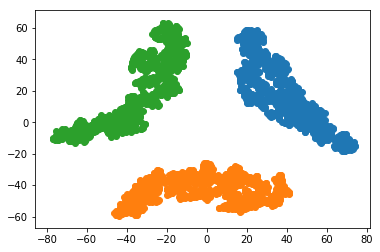

In [51]:
plt.scatter(z_embedded[:1024,0], z_embedded[:1024,1])
plt.scatter(z_embedded[1024:2048,0], z_embedded[1024:2048,1])
plt.scatter(z_embedded[2048:,0], z_embedded[2048:,1])